# Introduction

In this project, I will be using an unsupervised anomaly detection algorithm to detect fraudulent credit card transactions. The [dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) used in this project is a credit card fraud dataset from Kaggle containing anonymized credit card transactions made by European cardholders in September 2013.



# Data Understanding
The dataset, which can be found [here](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud), contains anonymized credit card transactions made over the course of two days in September 2013 by European cardholders.

Each transaction is labeled as fraudulent or genuine. There is a total of 285,807 transactions in the dataset, and only 492 are fraudulent. Thus, the dataset is highly unbalanced, with frauds accounting for only 0.172% of all transactions.

Due to confidentiality issues, the original features and more background information about the data is not available. As a result, features V1, V2, … V28 are the principal components obtained with PCA. The only features which have not been transformed with PCA are Time and Amount, where the Time feature contains the seconds elapsed between each transaction and the first transaction in the dataset.

The Class feature is the dependent variable and it takes value 1 in case of fraud and 0 otherwise.

# Data Preparation

## | Reading in the dataset
Let's load the dataset from Kaggle and import the necessary libraries.

*Note: You will need to download the Kaggle API token and place it in the runtime files. Find instructions [here](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/).*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import os

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download mlg-ulb/creditcardfraud
! unzip creditcardfraud.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 96% 63.0M/66.0M [00:00<00:00, 109MB/s] 
100% 66.0M/66.0M [00:00<00:00, 96.0MB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


##| Examining the data
Now let's load the data into a pandas dataframe, and take a peek at it using the head() function.

In [42]:
df = pd.read_csv("/content/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Now let's look at some basic information about the attributes and the structure of the dataframe.

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


And let's check if there are any NA values.

In [5]:
df.isnull().values.any()

False

# Data Visualization

Let's begin by plotting normal transactions vs frudulent transactions on a bar graph, in order to better visualize the fraction of anomalous transactions in the dataset.

Additionally, let's separate normal and fraudulent transactions in datasets of their own which will simplify the process of data visualization and model training later on.

(492, 31) (284315, 31)


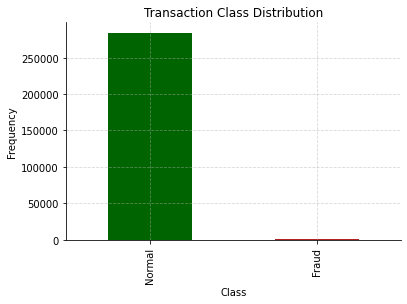

In [43]:
authenticity = pd.value_counts(df['Class'], sort = True)
authenticity.plot(kind = 'bar', color = ['#006400', '#B22222'], width = 0.5)

spines = plt.gca().spines
spines['top'].set_visible(False)
spines['right'].set_visible(False)

plt.grid(linestyle='--', alpha=0.5)

plt.title("Transaction Class Distribution")
plt.xticks(range(2), ["Normal", "Fraud"])
plt.xlabel("Class")
plt.ylabel("Frequency")

fraud = df[df['Class'] == 1]
normal = df[df['Class'] == 0]
print(fraud.shape, normal.shape)

Let's take also plot Time and Amount features for both types of transitions, and see if we can spot anything obvious which could help us differentiate between fraudulent and genuine transactions.

<ipython-input-44-0f441eb098ef>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  fraud.Axis = []
<ipython-input-44-0f441eb098ef>:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  normal.Axis = []


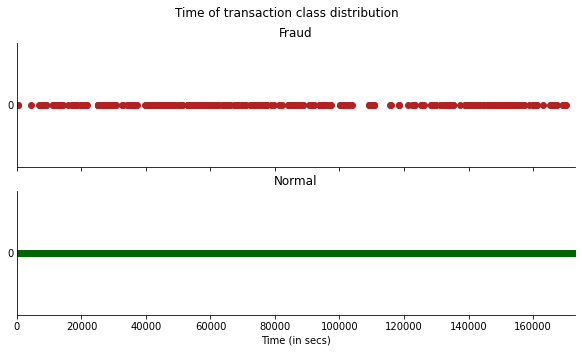

In [44]:
fraud.Axis = []
for i in range(0, 492):
  fraud.Axis.append(0)

normal.Axis = []
for i in range(0, 284315):
  normal.Axis.append(0)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
f.suptitle('Time of transaction class distribution')

ax1.scatter(fraud.Time, fraud.Axis, c="firebrick")
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Axis, c="darkgreen")
ax2.set_title('Normal')

plt.xlabel('Time (in secs)')
plt.xlim((0, 173000))

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax1.tick_params(axis='y', which='both', length=0)
ax2.tick_params(axis='y', which='both', length=0)
ax1.set_yticks([0])
ax2.set_yticks([0])

plt.show()

There is not much that can be inferred from the above graph since there doesn't seem to be a clear pattern to when fraudulent transactions occurred. If we take the center of the graph to be the approximate boundary between day one and day two, it almost looks like fraudulent transactions are more likely to occur later on in the day. In order to gain a clearer image it might also be useful to plot time for each day separately for fraudulent transactions.

<ipython-input-45-256f9566fe6d>:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dayOneFraud.Axis = []
<ipython-input-45-256f9566fe6d>:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dayTwoFraud.Axis = []


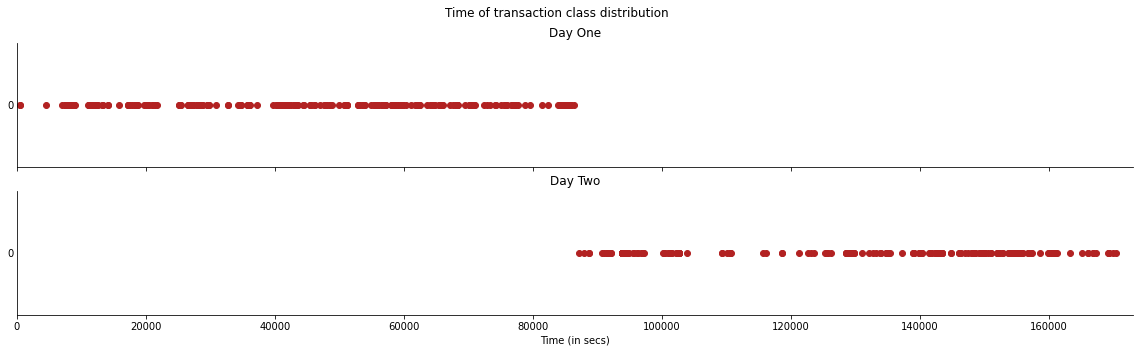

In [45]:
dayOneFraud = fraud[fraud['Time'] < 86400]
dayTwoFraud = fraud[fraud['Time'] >= 86400]

dayOneFraud.Axis = []
for i in range(0, 281):
  dayOneFraud.Axis.append(0)

dayTwoFraud.Axis = []
for i in range(0, 211):
  dayTwoFraud.Axis.append(0)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 5))
f.suptitle('Time of transaction class distribution')

ax1.scatter(dayOneFraud.Time, dayOneFraud.Axis, c="firebrick")
ax1.set_title('Day One')


ax2.scatter(dayTwoFraud.Time, dayTwoFraud.Axis, c="firebrick")
ax2.set_title('Day Two')

plt.xlabel('Time (in secs)')
plt.xlim((0, 173000))

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax1.tick_params(axis='y', which='both', length=0)
ax2.tick_params(axis='y', which='both', length=0)
ax1.set_yticks([0])
ax2.set_yticks([0])

plt.show()

It seems that the fraudulent transactions occur slightly more frequently later on in the day for both days. We'll keep this in mind for when we begin training the model.

Let's also graph amount for both types of transactions.

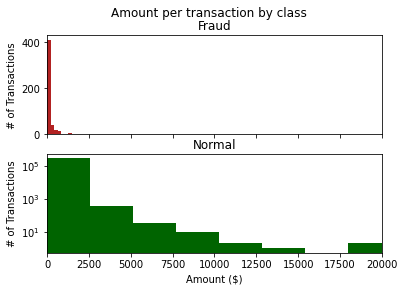

In [46]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 10
ax1.hist(fraud.Amount, bins = bins, color="firebrick")
ax1.set_title('Fraud')
ax1.set_ylabel('# of Transactions')
ax2.hist(normal.Amount, bins = bins, color="darkgreen")
ax2.set_title('Normal')
ax2.set_ylabel('# of Transactions')
plt.xlabel('Amount ($)')
plt.xlim((0, 20000))
plt.yscale('log')

Now we can see that most of the fraudulent transactions involve small amounts of money. It is true that the majority of genuine transactions are also small amount transactions, but there are transactions for all amounts which is not true for fraudulent transactions.

# Modeling
For this project, I will use an unsupervised anomaly detection model in order to detect fraudulent transactions.

##| Feature selection
In order to use an unsupervised model all features should be normally distributed. Let's look at the distributions of all of the features in our data.

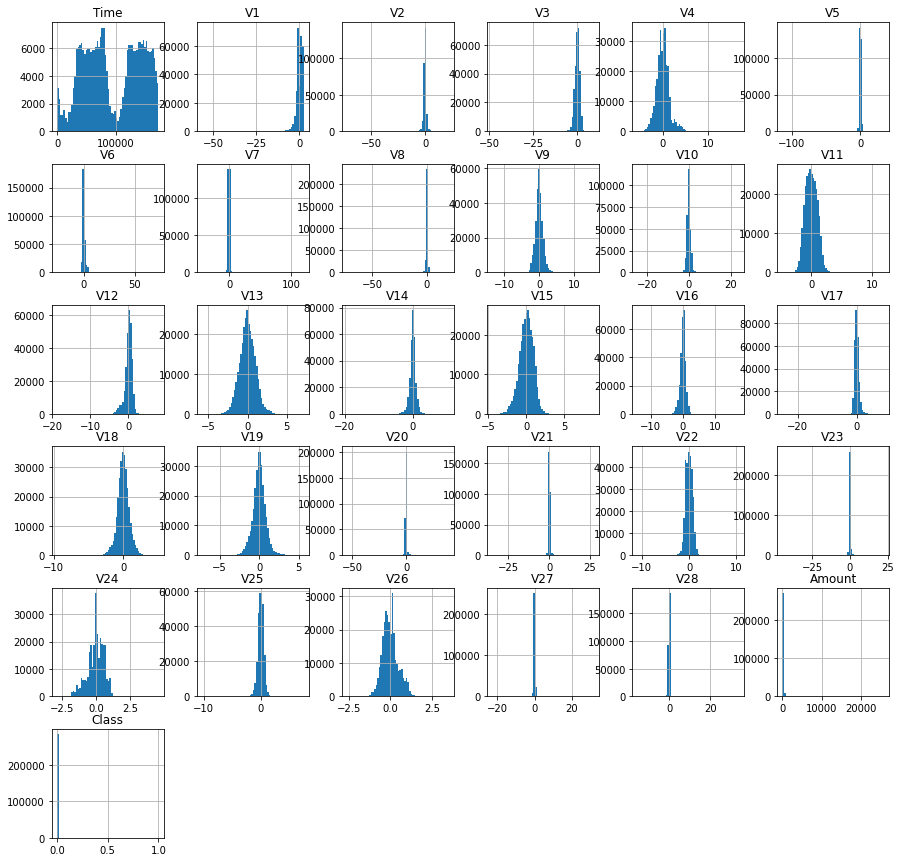

In [47]:
df.hist(figsize=(15,15), bins = 64)
plt.show()

Based on the above histograms, the features that don't look even remotely like a Gaussian distribution are Time, V1 and V24. The Time feature can, however, potentially be normalized by splitting the data into two separate days. However, since we visualized Time above, it's clear that even when split into two different days the data still isn't normally distributed. Additionally, without further knowledge of what V1 and V24 represent, it's best we drop these features alongside Time before proceeding with training a model.



In [48]:
df = df.drop(['Time', 'V1', 'V24'], axis=1)
df.head()

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V20,V21,V22,V23,V25,V26,V27,V28,Amount,Class
0,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,...,0.251412,-0.018307,0.277838,-0.110474,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,...,-0.069083,-0.225775,-0.638672,0.101288,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,...,0.524980,0.247998,0.771679,0.909412,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,...,-0.208038,-0.108300,0.005274,-0.190321,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,...,0.408542,-0.009431,0.798278,-0.137458,-0.206010,0.502292,0.219422,0.215153,69.99,0


##| Training
Since I am doing this work on Google Colab, I face time out issues when I attempt to train a model on the entire dataset. For that reason, I will sample 15% of the data available and divide that fraction into the training and the test set.

In [49]:
data = df.sample(frac = 0.15, random_state=1)

columns = data.columns.tolist()
columns = columns[:-1]

X_train = data.iloc[:32000, :-1]
y_train = data.iloc[:32000, -1]
X_test = data.iloc[32000:, :-1]
y_test = data.iloc[32000:, -1]

(32000, 27) (10721, 27)
(32000,) (10721,)


Now I will use LocalOutlierFactor function from the scikit-learn library in order to use unsupervised learning to train the model.

In [50]:
model = LocalOutlierFactor(contamination = len(fraud)/float(len(normal)))

y_train_pred = model.fit_predict(X_train)

y_train_pred[y_train_pred == 1] = 0
y_train_pred[y_train_pred == -1] = 1

y_test_pred = model.fit_predict(X_test)

y_test_pred[y_test_pred == 1] = 0
y_test_pred[y_test_pred == -1] = 1

##| Model Evaluation

When dealing with an extremely unbalanced dataset, judging a model by its accuracy is not appropriate. An alternative option is using a confusion matrix. Let's create a helper function which will plot a confusion matrix for us since we want to see the model's performance on both the training and the test set.


In [51]:
import itertools
classes = np.array(['0','1'])
def plot_confusion_matrix(cm, classes,title='Confusion matrix', cmap=plt.cm.Greens):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
    horizontalalignment="center",
    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Let's use the model on the training set and see what the confusion matrix says.

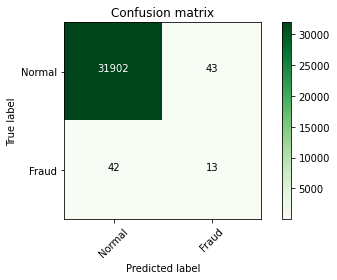

In [52]:
cm_train = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm_train,["Normal", "Fraud"])

The above confusion matrix tells us that the model correctly classified 31902  genuine transactions and 13 fraudulent transactions. However, it incorrectly classified 43 genuine transactions as fraudulent, which is not the end of the world. Much more concerning is the fact that it incorrectly classified 42 fraudulent transactions as genuine. A false genuine transaction can do much more damage to a system than a false fraudulent transaction prediction.

Let's see how the model fares with the test data.

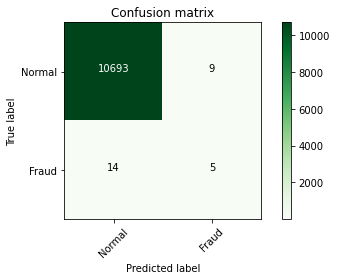

In [53]:
cm_test = confusion_matrix(y_test_pred, y_test)
plot_confusion_matrix(cm_test,["Normal", "Fraud"])

When deployed on unfamiliar data, the model correctly classified 10693 genuine transactions and 5 fraudulent transactions. However, it incorrectly classified 9 genuine transactions as fraudulent, and 14 fraudulent transactions as genuine.

# To-do
Although better than a random guess, the above model is far from perfection. Here are some ideas I have for how this model could be improved:

* Use feature engineering and consider additional derived features that might be informative for detecting fraud
* Try a different unsupervised learning algorithm, such as clustering
* Use ensemble learning where the final prediction is based on the combined outputs of all models which can help  reduce the impact of any one model's weaknesses
* Evaluate the model's performance using different metrics such as precision, recall, F1-score, and ROC-AUC
* Incorporate deep learning techniques



# Acknowledgements

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of Université Libre de Bruxelles on big data mining and fraud detection.

| Citations

Bajaj, Vardaan. “Unsupervised Learning for Anomaly Detection.” Medium, 9 Aug. 2020, [towardsdatascience.com/unsupervised-learning-for-anomaly-detection-44c55a96b8c1](https://towardsdatascience.com/unsupervised-learning-for-anomaly-detection-44c55a96b8c1). Accessed 28 Feb. 2023.